**Юнит 4 Проект 2 Разведывательный анализ данных**  
Работа Иванько Натальи (19_group_dst-9)

# Задание

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Cделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

In [311]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [312]:
# импортируем датасет, устанавливаем опцию для вывода не менее 30 колонок на просмотр и выводим первые 5 записей
df = pd.read_csv('stud_math.csv')
pd.set_option('display.max_columns', 30)
display(df.head(5))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [313]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

**Первичный анализ датасета показал следующее:**
 - база содержит 395 записей, большинство из которых имеет пропуски по тем или иным признакам
 - база содержит 30 колонок: 29 признаков и 1 столбец с целевой переменной (score)  
17 признаков являются категориальными, 12 числовыми, из которых вероятно 10 являются ранговыми.

## Анализ целевой переменной

In [314]:
df.loc[:, ['score']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


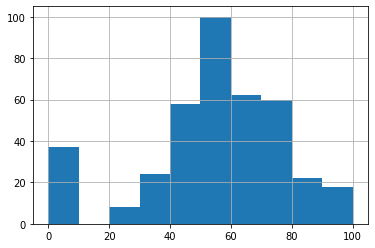

In [315]:
df.score.hist()

In [316]:
df[df.score==0].score.count()

37

Обращает на себя внимание наличие данных со значением '0'. Поскольку их доля составляет почти 10% от общего числа наблюдений, предположим, что это результат, который в будущем также может быть получен с некоторой вероятностью (возможно аннулирование результатов работы или неявка на экзамен).   
Кроме того, колонка с целевой переменной содержит 6 незаполненных значений. Поскольку строки с этими значениями не могут быть использованы для прогнозирования, удалим их из датасета.

In [317]:
df = df.dropna(subset=['score'],axis=0)

## Анализ и предварительная обработка признаков
В качестве первого этапа работы осуществим анализ каждого признака на предмет наличия незаполненных значений, ошибок и выбросов и попытаемся выбрать метод обработки пропусков для каждого признака.

**school - аббревиатура школы, в которой учится ученик**

In [318]:
pd.DataFrame(df.school.value_counts())

,school
GP,344
MS,45


Столбец с аббривеатурами школ содержит два значения, не имеет пропусков, в дальнейшем его необходимо обработать методом get_dummies.

In [319]:
pd.DataFrame(df.school.value_counts(normalize=True))

,school
GP,0.884319
MS,0.115681


Отметим, что значение 'GP' является превалирующим и составляет более 88%, это необходимо будет учесть при выборе варианта разбиения данных на обучающую и валидационную части.

**sex -  пол ученика ('F' - женский, 'M' - мужской)**

In [320]:
pd.DataFrame(df.sex.value_counts())

,sex
F,204
M,185


Столбец с указанием пола ученика не имеет пропусков, распределение признака практически равномерное, данные не нуждаются в дополнительной обработке (только методом get_dummies).

**age -  возраст ученика (от 15 до 22)**

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

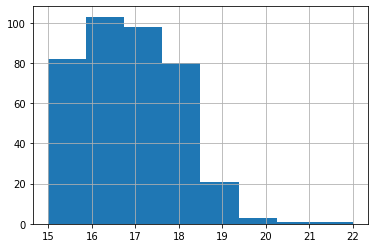

In [321]:
df.age.hist(bins=8)
df.age.describe()

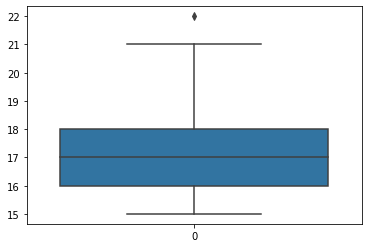

In [322]:
sns.boxplot(data=df.age)

Посмотрим корреляцию признака с целевой переменной.

In [323]:
corr = df[['age', 'score']].corr(method="pearson")
corr

,age,score
age,1.000000,-0.155726
score,-0.155726,1.000000


По признаку "возраст ученика" данные заполнены без пропусков, межквартильный размах сосредоточен в возрасте от 16 до 18 лет.  
Boxplot определил значение 22 как выброс, однако, по условию задания возраст учеников в датасете включает 22 года, кроме того,
значение 22 года и значение 21 год в данных имеют по одной записи - это дает основание оставить эти записи в данных.
Можно предположить, что потребность сдавать экзамен по математике в возрасте старше 18 лет может быть вызвана неуспеваемостью.
Отрицательная корреляция -0,15 свидетельствует о том, что с увеличением возраста целевая переменная снижается, что может быть вызвано усложнением экзаменов и более низкой успеваемостью в возрасте старше 18 лет.

**address - тип адреса ученика ('U' - городской, 'R' - за городом)**

In [324]:
pd.DataFrame(df.address.isna()).sum()

address    15
dtype: int64

15 незаполненных значений составляют около 4% от датасета, постараемся найти возможность заполнить пропуски.
В датасете имеется признак traveltime - время в пути до школы. Сопоставим частоту распределения признака traveltime в группировках по признаку school и adress.

In [325]:
df.groupby(['school','address','traveltime'])['school'].count()

school  address  traveltime
GP      R        1.0            29
                 2.0            18
                 3.0             5
                 4.0             3
        U        1.0           190
                 2.0            54
                 3.0             9
                 4.0             3
MS      R        1.0             5
                 2.0             8
                 3.0             7
                 4.0             1
        U        1.0             8
                 2.0             9
Name: school, dtype: int64

У учеников школы GP 11 записей имеют пропуск в поле address. 7 из них имеют признак traveltime = 1; 2 записи имеют признак = 2.
Среди заполненных записей по школе GP с признаком traveltime 1 или 2 (время в пути до школы менее 30 минут), 244 ученика или 84% проживают в городе.
Поэтому логичным будет заполнить пустые значения признака address по школе GP значением "U" (городской).

In [326]:
df.loc[(df['school'] == 'GP') & (df.address.isnull()) , 'address'] = 'U'

У учеников школы MS пропуск в поле address имеют 4 записи, 3 из них имеют признак traveltime = 2. Среди заполненных данных по школе MS со значением traveltime, равным 2, признак address распределся примерно поровну. Заполним два пропуска значением "R", два пропуска - значением "U", дополнительно опираясь на значение колонки reason.

In [327]:
df.loc[(df['school'] == 'MS') & (df['reason'] == 'home') & (df.address.isnull()) , 'address'] = 'U'

In [328]:
df.loc[(df['school'] == 'MS') & (df['reason'] == 'course') & (df.address.isnull()) , 'address'] = 'R'

U    0.781491
R    0.218509
Name: address, dtype: float64

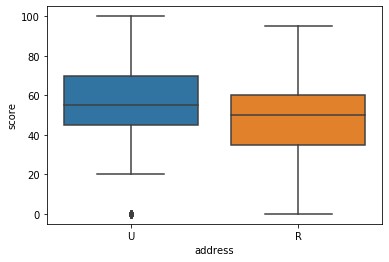

In [329]:
display(sns.boxplot(x='address', y='score', data=df), df.address.value_counts(normalize=True))

78% учеников проживают в городе и их экзаменационные оценкиу выше, чем оценки учеников, приживающих за городом. 

**famsize — размер семьи('LE3' <= 3, 'GT3' >3) и**  
**Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)**

In [330]:
pd.DataFrame(df.famsize.value_counts())

,famsize
GT3,255
LE3,107


In [331]:
pd.DataFrame(df.Pstatus.value_counts())

,Pstatus
T,308
A,36


Воспользуемся функцией для построения боксплотов по списку колонок из тренировочного проекта.

In [332]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (8, 3))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

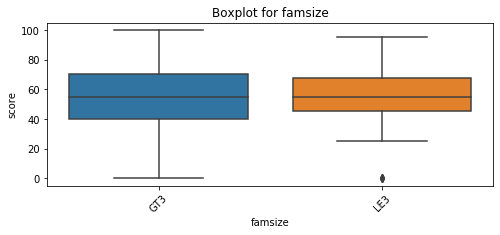

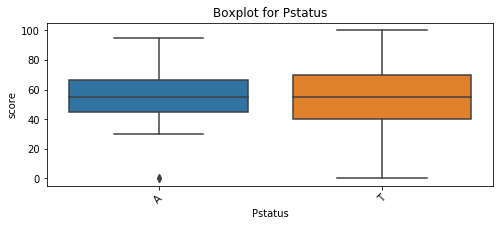

In [333]:
for col in ['famsize', 'Pstatus']:
    get_boxplot(col)

Оба показателя в основной своей массе сосредоточены в пределах от 40 до 70 баллов по экзамену, ровно эти границы являются межвкартильным размахом целевой переменной.
Возможно предположение, что характер их влияния на целевую переменную может быть схож и скорее всего несущественен. Причем заметно похожее распределение между признаками GT3 -  T и признаками LE3  -  A.   
Исходя из этого одним из вариантов обработки этих призников было введение дополнительного признака, объединяющего значение колонок famsize и Pstatus. Таким образом новый признак был заполнен следующими значениями: GT3-A, GT3-T, GT3, LE3-A, LE3-T, LE3, A, T. Пустые значения по новому признаку оказались в 4х строках, которые были заполнены значением GT3-T как явно доминирующим (55%) среди остальных.   
Второй вариант обработки признаков состоял в том, чтобы заполнить попуски новым значением "No'.   
Третий вариант - заполнить пропуски значениями, имеющими бОльшую долю в признаке (GT3 и Т соответственно).   
При обучении тестовой модели первый вариант выдал результат, совпадающий с третьим. Результат второго варианта оказался хуже.
Таким образом, чтобы не усложнять модель дополнительным признаком, был выбран вариант заполнения пропусков наиболее распространенными значениями.

In [334]:
df.loc[(df.famsize.isnull()) , 'famsize'] = 'GT3'
df.loc[(df.Pstatus.isnull()) , 'Pstatus'] = 'T'

**Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)**  
**Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)**

In [335]:
pd.DataFrame(df.Medu.value_counts())

,Medu
4.0,131
2.0,100
3.0,96
1.0,56
0.0,3


In [336]:
pd.DataFrame(df.Medu.isna()).sum()

Medu    3
dtype: int64

Признак содержит 3 незаполненные записи, Посмотрим, как часто совпадает значение признаков Medu и Fedu:

In [337]:
df.loc[(df['Medu'] == df['Fedu'])]['Medu'].count()

177

Поскольку у 45% наблюдений уровень образования матери и отца совпадает, есть основание заполнить пропуски признака Medu значением признака Fedu.

In [338]:
df['Medu'] = df.apply(lambda x : fill_Values_Medu(x),axis=1)

Аналогично посмотрим признак Fedu:

In [339]:
pd.DataFrame(df.Fedu.value_counts())

,Fedu
2.0,105
3.0,94
4.0,88
1.0,75
0.0,2
40.0,1


По признаку Fedu в датасете присутствует одно ошибочное значение, равное 40. Оно противоречит описанию признака и определенно является ошибкой заполнения. Логично это значение перезаписать на значение, равное 4.

In [340]:
df.loc[df['Fedu'] == 40.0, 'Fedu'] = 4.0

In [341]:
pd.DataFrame(df.Fedu.isna()).sum()

Fedu    24
dtype: int64

До того, как принимать решение о необходимости заполнения 24 пропущенных значений признака Fedu посмотрим на распределение признаков Medu и Fedu на боксплотах.

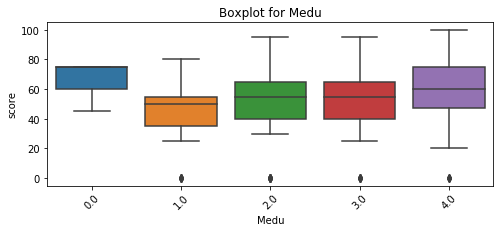

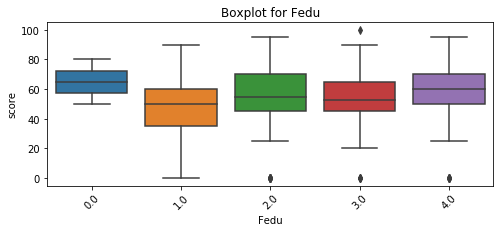

In [342]:
for col in ['Medu', 'Fedu']:
    get_boxplot(col)

Есть основания предположить, что признаки Medu и Fedu имеют влияние на значение целевой переменной, наблюдается разнообразное распределение переменной в рамках значений признаков.  Несколько нелогичным выглядит практически максимальное значение переменной у учеников, родители которых не имеют образования (признак равен 0). Причина состоит в том, что таких записей в датасете всего 3 у признака Medu и 2 у признака Fedu и ввиду незначительного количества таких записей нет повода считать это аномалией.   
В любом случае, по смыслу признаки логично обрабатывать как ранговые, предполагающие, что более качественное образование имеет более высокую оценку.   
В связи с этим посмотрим на значения коэффициента Спирмена, как показателя ранговой корреляции.

In [343]:
scipy.stats.spearmanr(df.Medu, df.score)

SpearmanrResult(correlation=0.22591752644551688, pvalue=6.803096163702682e-06)

In [344]:
df_temp = df[['Fedu', 'score']].dropna()
scipy.stats.spearmanr(df_temp.Fedu, df_temp.score)

SpearmanrResult(correlation=0.14995464063058594, pvalue=0.004087810711464127)

Зависимость целевой переменной от признака Medu больше, чем признака Fedu. 
Обработаем пропуски признака Fedu аналогично, заполнив из значениями из признака Medu.

In [345]:
df['Fedu'] = df.apply(lambda x : fill_Values_Fedu(x),axis=1)

**Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)**   
**Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)**

In [346]:
display(pd.DataFrame(df.Mjob.describe()), pd.DataFrame(df.Fjob.describe()))

,Mjob
count,370
unique,5
top,other
freq,127


,Fjob
count,353
unique,5
top,other
freq,194


In [347]:
display(df.Mjob.value_counts(), df.Fjob.value_counts())

other       127
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

other       194
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

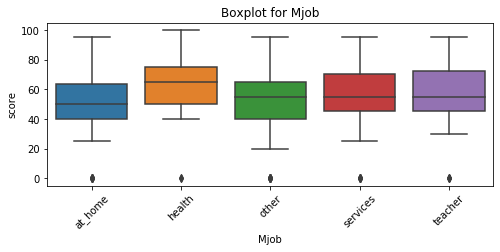

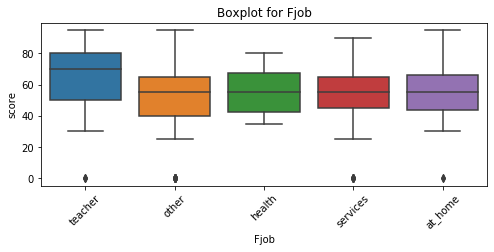

In [348]:
for col in ['Mjob', 'Fjob']:
    get_boxplot(col)

Анализ признаков показывает, что наиболее распространенным является значение признаков 'other'. По смыслу логично незаполненные записи также считать представителями 'иного' вида занятости. Выше оценки учеников, родители которых являются учителями и врачами.

In [349]:
df.loc[(df.Mjob.isnull()) , 'Mjob'] = 'other'
df.loc[(df.Fjob.isnull()) , 'Fjob'] = 'other'

**reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)**

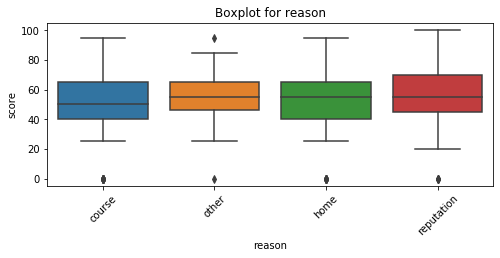

,reason
count,372
unique,4
top,course
freq,135


course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

None

Количество незаполненных значений  17


In [350]:
display(pd.DataFrame(df.reason.describe()), df.reason.value_counts(), get_boxplot('reason'))
print('Количество незаполненных значений ', df.reason.isna().sum())

Признак содержит 17 пропущенных значений. Судя по распределению на боксплоте, признак скорее всего не оказывает существенного влияния на целевую переменную. Тем не менее, пока осуществим заполнение пропущенных значений, логичнее всего сделать это значением 'other'.

In [351]:
df.loc[(df.reason.isnull()) , 'reason'] = 'other'

**guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)**

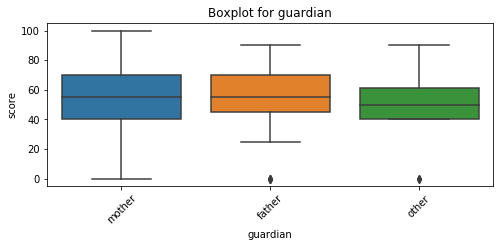

,guardian
count,358
unique,3
top,mother
freq,248


mother    248
father     86
other      24
Name: guardian, dtype: int64

None

Количество незаполненных значений  31


In [352]:
display(pd.DataFrame(df.guardian.describe()), df.guardian.value_counts(), get_boxplot('guardian'))
print('Количество незаполненных значений ', df.guardian.isna().sum())

Признак содержит 31 пропущенное значение и скорее всего не оказывает существенного влияния на целевую переменную. Тем не менее, пока осуществим заполнение пропущенных значений. В данном случае заполнение произведем наиболее распространенным значением 'mother', которое встречается чаще почти в 3 раза, чем 'father' и в 10 раз, чем 'other',

In [353]:
df.guardian.fillna(df['guardian'].describe()['top'], inplace=True)

**traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)**

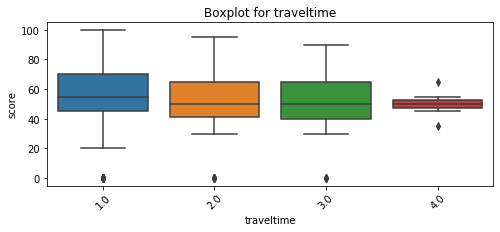

1.0    239
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

None

Количество незаполненных значений  28


In [354]:
display(df.traveltime.value_counts(), get_boxplot('traveltime'))
print('Количество незаполненных значений ', df.traveltime.isna().sum())

Признак содержит 28 пропущенных значений и аналогично двум предыдущим скорее всего не оказывает существенного влияния на целевую переменную. Также осуществим заполнение пропущенных значений наиболее распространенным значением '1'. Этот признак несмотря на тип данных float64 является категориальным.

In [355]:
df.traveltime.fillna(df['traveltime'].value_counts().index[0], inplace=True)

**studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)**

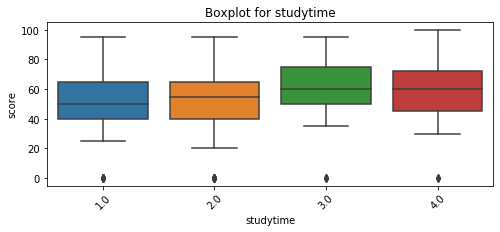

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

None

Медианное значение признака  2.0
Количество незаполненных значений  7


In [356]:
display(df.studytime.value_counts(), get_boxplot('studytime'))
print('Медианное значение признака ', df.studytime.median())
print('Количество незаполненных значений ', df.studytime.isna().sum())

Признак затрачиваемого на учебу времени может оказаться более значимым для прогнозирования целевой переменной. Он содержит 7 пропущенных значений, которые заполним наиболее распространенным и медианным значением '2'. Можно предположить, что признак является ранговым, т.е. чем больше времени ученик затрачивает на учебу, тем лучше результатов можно от него ожидать.

In [357]:
df.studytime.fillna(df['studytime'].median(), inplace=True)

In [358]:
scipy.stats.spearmanr(df.studytime, df.score)

SpearmanrResult(correlation=0.12224292927467556, pvalue=0.01585214496022439)

Коэффициент Спирмена показывает незначительную корреляцию признака с целевой переменной. Интересно распределение значения '4' относительно целевой переменной - его уровни ниже, чем у значения '3'. Т.е. длительные занятия могут быть вызваны не усердием ученика, а каоборот, слабыми способностями.

**failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)**

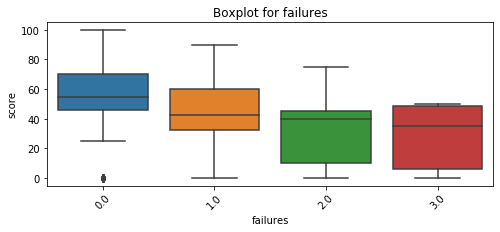

0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

None

Медианное значение признака  0.0
Количество незаполненных значений  22


In [359]:
display(df.failures.value_counts(), get_boxplot('failures'))
print('Медианное значение признака ', df.failures.median())
print('Количество незаполненных значений ', df.failures.isna().sum())

Наконец то дождались признака, имеющего влияние на целевую переменную, по боксплоту видна обратная корреляция - с увеличением количества неудач ухудшается значение целевой переменной. Пропуски заполним наиболее частым и медианным значением '0'.

In [360]:
df.failures.fillna(df['failures'].median(), inplace=True)

In [361]:
scipy.stats.spearmanr(df.failures, df.score)

SpearmanrResult(correlation=-0.34593821865268837, pvalue=2.2363589136141204e-12)

Признак имеет слабую обратную корреляцию с целевой переменной, будем использовать его в модели как ранговый признак.

**schoolsup — дополнительная образовательная поддержка (yes или no)**

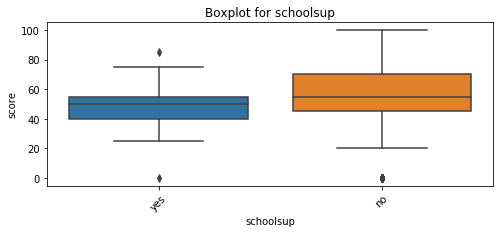

no     331
yes     49
Name: schoolsup, dtype: int64

None

Количество незаполненных значений  9


In [362]:
display(df.schoolsup.value_counts(), get_boxplot('schoolsup'))
print('Количество незаполненных значений ', df.schoolsup.isna().sum())

Признак бинарный, логично было бы ожидать, что наличие дополнительных образовательных мероприятий должно положительно влиять на оценку. Однако на боксплоте мы видим обратную ситуацию - оценки учеников, не занимающихся дополнительно в своем большинстве лучше учеников с допзанятиями. Причина скорее всего в значительной непропорциональности - значение 'no' встречается почти в 7 раз чаще, 'yes'. Осуществим замену строковых значений на 0 для 'no' и 1 для 'yes'. Пропуски заполним самым частотным значением.

In [363]:
df.schoolsup.fillna(df['schoolsup'].describe()['top'], inplace=True)

In [364]:
df['schoolsup'] = df.schoolsup.apply(lambda x : 1 if x=='yes' else 0)

**famsup — семейная образовательная поддержка (yes или no)**

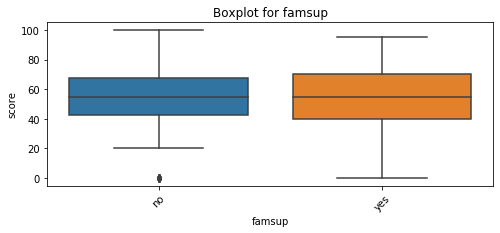

yes    216
no     135
Name: famsup, dtype: int64

None

Количество незаполненных значений  38


In [365]:
display(df.famsup.value_counts(), get_boxplot('famsup'))
print('Количество незаполненных значений ', df.famsup.isna().sum())

Признак кажется малоинформативным, имеет 38 пропущенных значений, обработаем его следующим образом: значению 'no' присвоим -1, значению 'yes' присвои значение 1, пропуски заполним значением 0, как аналог 'не известно'.

In [366]:
df.famsup = df.famsup.apply(lambda x : 1 if x=='yes' else -1 if x=='no' else 0)

**paid — дополнительные платные занятия по математике (yes или no)**

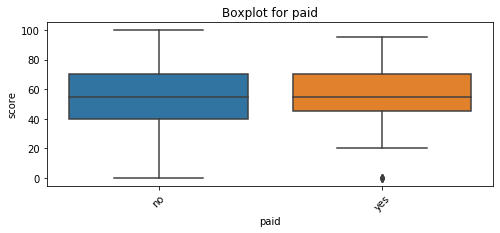

no     197
yes    153
Name: paid, dtype: int64

None

Количество незаполненных значений  39


In [367]:
display(df.paid.value_counts(), get_boxplot('paid'))
print('Количество незаполненных значений ', df.paid.isna().sum())

Признак по распределению похож на предыдущий, имеет 39 пропущенных значений, обработаем его аналогично.

In [368]:
df.paid = df.paid.apply(lambda x : 1 if x=='yes' else -1 if x=='no' else 0)

**activities — дополнительные внеучебные занятия (yes или no)**

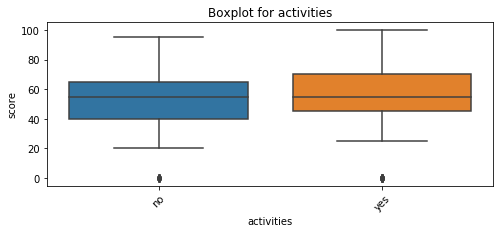

yes    192
no     183
Name: activities, dtype: int64

None

Количество незаполненных значений  14


In [369]:
display(df.activities.value_counts(), get_boxplot('activities'))
print('Количество незаполненных значений ', df.activities.isna().sum())

Признак по распределению похож на два предыдущих, имеет 14 пропущенных значений, обработаем его аналогично.

In [370]:
df.activities = df.activities.apply(lambda x : 1 if x=='yes' else -1 if x=='no' else 0)

**nursery — посещал детский сад (yes или no)**

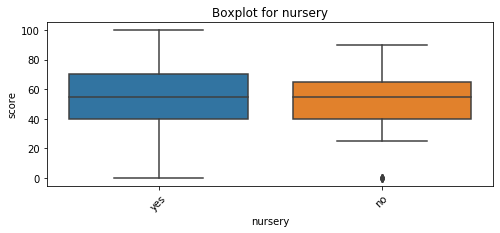

yes    297
no      77
Name: nursery, dtype: int64

None

Количество незаполненных значений  15


In [371]:
display(df.nursery.value_counts(), get_boxplot('nursery'))
print('Количество незаполненных значений ', df.nursery.isna().sum())

Признак по распределению похож на три предыдущих, маловероятно, что он влияет на целевую переменную. Имеется 15 пропущенных значений, заполним их наиболее часто встречающимся значением 'yes' и переведем значения в числовой формат.

In [372]:
df.nursery = df.nursery.apply(lambda x : 0 if x=='no' else 1)

**studytime, granular (признак отсутствует в описании датасета)**

In [373]:
df = df.rename(columns={'studytime, granular' : 'studytime_granular'})

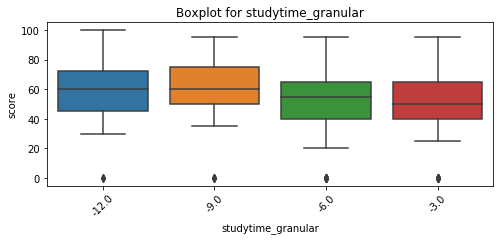

-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime_granular, dtype: int64

None

Количество незаполненных значений  7


In [374]:
display(df['studytime_granular'].value_counts(), get_boxplot('studytime_granular'))
print('Количество незаполненных значений ', df['studytime_granular'].isna().sum())

Вспомним распределение признака studytime

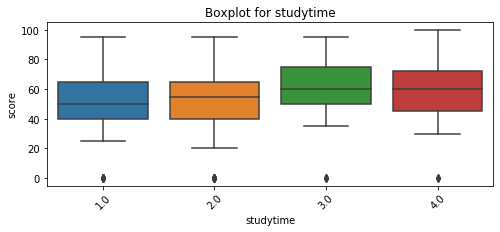

2.0    196
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

None

In [375]:
display(df['studytime'].value_counts(), get_boxplot('studytime'))

Распределение зеркальное и совпадает по количеству, за исключением 7 уже обработанных ранее записей. Проверим версию через коэффициент корреляции.

In [376]:
df[['studytime', 'studytime_granular']].corr(method="pearson")

,studytime,studytime_granular
studytime,1.0,-1.0
studytime_granular,-1.0,1.0


Полная корреляция показывает, что признак studytime, granular вероятно является производным от признака studytime и подлежит удалению из датасета.

In [377]:
df.drop(['studytime_granular'], inplace = True, axis = 1)

**higher — хочет получить высшее образование (yes или no)**

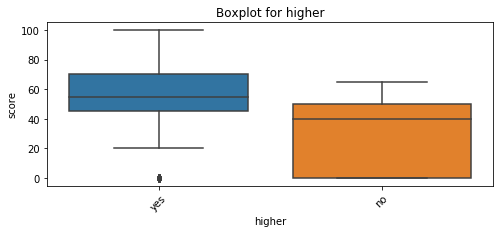

yes    350
no      19
Name: higher, dtype: int64

None

Количество незаполненных значений  20


In [378]:
display(df.higher.value_counts(), get_boxplot('higher'))
print('Количество незаполненных значений ', df.higher.isna().sum())

Заметна существенная разница распределения переменной в зависимости от признака. Признак может быть полезным для модели, в данном случае выбираем заполнение пропусков нейтральным значением '0', которое по частотности повторит одно из значений признака.

In [379]:
df.higher = df.higher.apply(lambda x : 1 if x=='yes' else -1 if x=='no' else 0)

**internet — наличие интернета дома (yes или no)**

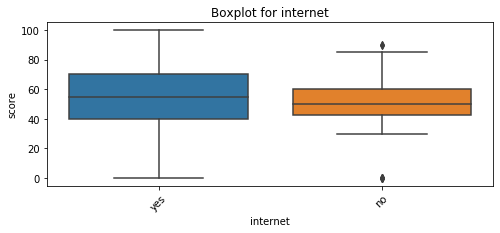

yes    300
no      55
Name: internet, dtype: int64

yes    0.84507
no     0.15493
Name: internet, dtype: float64

None

Количество незаполненных значений  34


In [380]:
display(df.internet.value_counts(), df.internet.value_counts(normalize=True), get_boxplot('internet'))
print('Количество незаполненных значений ', df.internet.isna().sum())

Признак скорее всего окажется бесполезным для модели, поскольку одно значение признака имеет частотность 85%, а менее распространенное значение имеет величину целевой переменной в том же диапазоне. Поскольку незаполненных данных довольно много, выбираем заполнение пропусков нейтральным значением '0'.

In [381]:
df.internet = df.internet.apply(lambda x : 1 if x=='yes' else -1 if x=='no' else 0)

**romantic — в романтических отношениях (yes или no)**

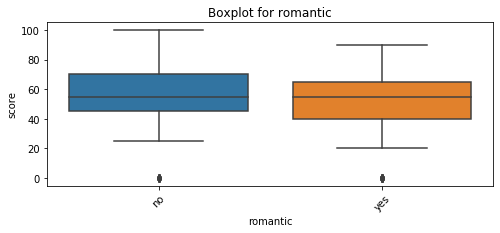

no     235
yes    123
Name: romantic, dtype: int64

None

Количество незаполненных значений  31


In [382]:
display(df.romantic.value_counts(), get_boxplot('romantic'))
print('Количество незаполненных значений ', df.romantic.isna().sum())

В данном случае боксплот не позволяет сделать вывод о полезности признака. Доля пропущенных значений существенна, выберем также заполнение третьим значением, аналогом "no_data". Однако работать с этим признаком будем как с категораильным, поскольку в данном случае ранговость значений неприменима.

In [383]:
df.romantic = df.romantic.apply(lambda x : 1 if x=='yes' else -1 if x=='no' else 0)

**famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)**

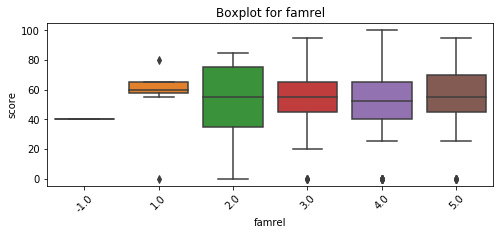

 4.0    178
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

None

Медианное значение признака  4.0
Количество незаполненных значений  27


In [384]:
display(df.famrel.value_counts(), get_boxplot('famrel'))
print('Медианное значение признака ', df.famrel.median())
print('Количество незаполненных значений ', df.famrel.isna().sum())

Выявляем одно ошибочное значение признака, равное -1, поскольку такое значение отсутствует в описании датасета. Осуществим его замену на значение 1, предположив, что ошибка заполнения была допущена в знаке. Существующие пропуски заменим на самое распространенное значение, которое является медианой, равное 4. 

In [385]:
df.loc[df['famrel'] == -1.0, 'famrel'] = 1.0

In [386]:
df.famrel.fillna(df['famrel'].median(), inplace=True)

**freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)**

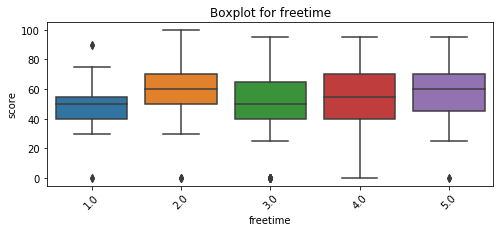

3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

None

Медианное значение признака  3.0
Количество незаполненных значений  9


In [387]:
display(df.freetime.value_counts(), get_boxplot('freetime'))
print('Медианное значение признака ', df.freetime.median())
print('Количество незаполненных значений ', df.freetime.isna().sum())

Визуализация распределения признака не позволяет сделать вывод о его влиянии на целевую переменную. 9 пропущенных значений заполним самым частотным признаком.

In [388]:
df.freetime.fillna(df['freetime'].median(), inplace=True)

**goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)**

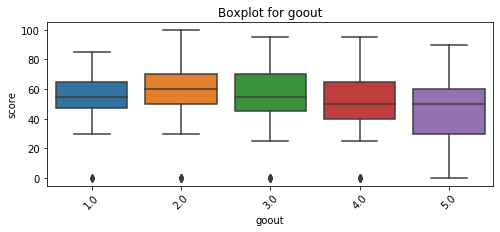

3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

None

Медианное значение признака  3.0
Количество незаполненных значений  7


In [389]:
display(df.goout.value_counts(), get_boxplot('goout'))
print('Медианное значение признака ', df.goout.median())
print('Количество незаполненных значений ', df.goout.isna().sum())

Аналогично предыдущему признаку пропущенные значения заменим наиболее частотным. 

In [390]:
df.goout.fillna(df['goout'].median(), inplace=True)

**health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)**

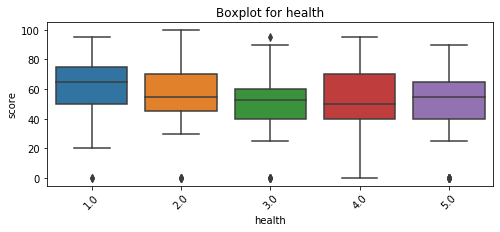

5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64

None

Медианное значение признака  4.0
Количество незаполненных значений  15


In [391]:
display(df.health.value_counts(), get_boxplot('health'))
print('Медианное значение признака ', df.health.median())
print('Количество незаполненных значений ', df.health.isna().sum())

Распределение признака достаточно равномерное. Пропущенные значения заполним медианным значением 4, как неким усредненным показателем.

In [392]:
df.health.fillna(df['health'].median(), inplace=True)

**absences — количество пропущенных занятий**

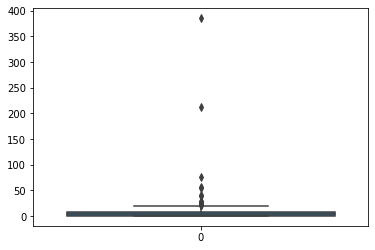

In [393]:
sns.boxplot(data=df.absences)

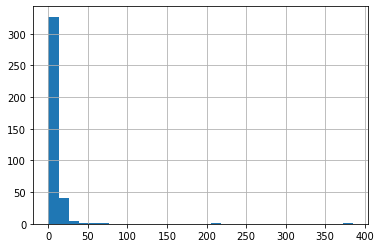

In [394]:
df.absences.hist(bins=30)

In [395]:
df.absences.describe()

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

По признаку absences боксплот и гистограмма показывают явное наличие выбросов. Визуально значения больше 30 можно считать выбросами, особенно учитывая, что 75% перцинтиль имеет значение 8.

In [396]:
df[df['absences']>30]['absences']

74      54.0
183     56.0
222    385.0
276     75.0
307     38.0
315     40.0
390    212.0
Name: absences, dtype: float64

Всего 7 значений признака превышают величину 30, заменим эти значения на число 30.

In [397]:
df.absences = df.absences.apply(lambda x : 30 if x>30 else x)

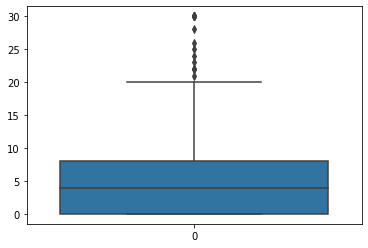

In [398]:
sns.boxplot(data=df.absences)

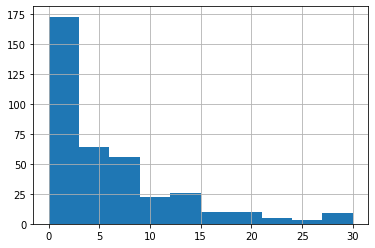

In [399]:
df.absences.hist()

In [400]:
df.absences.isna().sum()

11

Пропуски в количестве 11 штук заполним медианным значением.

In [401]:
df.absences.median()

4.0

In [402]:
df.absences.fillna(df['absences'].median(), inplace=True)

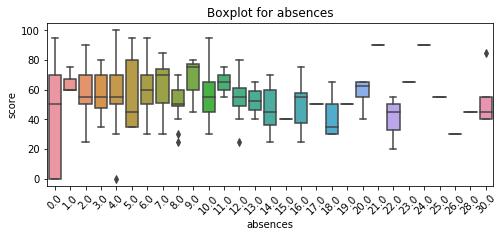

In [403]:
get_boxplot('absences')

Судя по распределению на боксплоте, признак не оказываюет значительное влияние на целевую переменную.

## Анализ зависимостей признаков между собой и с целевой переменной.

Проведем корреляционный анализ числовых переменных.

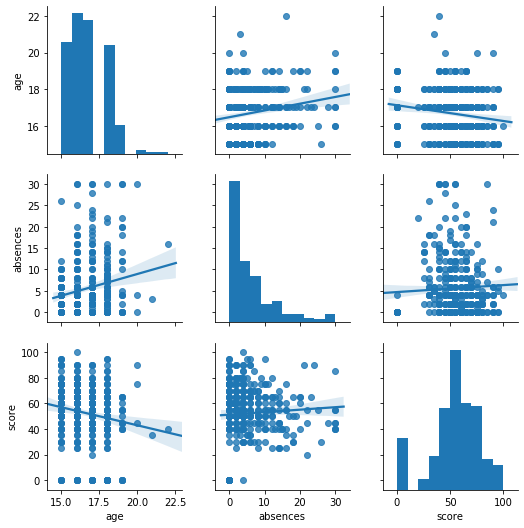

In [404]:
sns.pairplot(df[['age', 'absences', 'score']], kind = 'reg')

In [405]:
df[['age', 'absences', 'score']].corr()

,age,absences,score
age,1.000000,0.193790,-0.155726
absences,0.193790,1.000000,0.056284
score,-0.155726,0.056284,1.000000


Сильной корелляционной зависимости между переменными age и absences не выявлено, хоть и зависимость количества пропущенных занятий от  возраста даже немного сильнее, чем зависимость целевой переменной от возраста и количества пропущенных занятий. В любом случае, есть смысл включить в модель оба числовых признака.

Проведем анализ наличия статистической разницы в распределении оценок по качественным признакам с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения экзаменационных оценок по различным признакам неразличимы.

In [406]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'].dropna(),
                          df.loc[df.loc[:, column] == comb[1], 'score'].dropna()).pvalue
        if  ttest<= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('!Найдены статистически значимые различия для колонки!', column)
            break

In [407]:
listing = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
           'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
           'internet', 'romantic', 'famrel', 'freetime', 'goout','health']

In [408]:
for col in listing:
    get_stat_dif(col)

!Найдены статистически значимые различия для колонки! address
!Найдены статистически значимые различия для колонки! Medu
!Найдены статистически значимые различия для колонки! Fedu
!Найдены статистически значимые различия для колонки! Mjob
!Найдены статистически значимые различия для колонки! failures
!Найдены статистически значимые различия для колонки! higher
!Найдены статистически значимые различия для колонки! romantic


Дополнительно проанализируем ранговые переменные на предмет наличия ранговой корреляции с целевой переменной с помощью теста Спирмена.

In [409]:
listing_rang = ['Medu', 'Fedu', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
                'internet', 'famrel', 'freetime', 'goout','health']

In [410]:
for col in listing_rang:
    print(col, ' - ', scipy.stats.spearmanr(df[col], df.score))

Medu  -  SpearmanrResult(correlation=0.22591752644551688, pvalue=6.803096163702682e-06)
Fedu  -  SpearmanrResult(correlation=0.14832953075181465, pvalue=0.0033642011341178764)
studytime  -  SpearmanrResult(correlation=0.12224292927467556, pvalue=0.01585214496022439)
failures  -  SpearmanrResult(correlation=-0.34593821865268837, pvalue=2.2363589136141204e-12)
schoolsup  -  SpearmanrResult(correlation=-0.15303119467870646, pvalue=0.002475021972121437)
famsup  -  SpearmanrResult(correlation=-0.025776025268759176, pvalue=0.6122735000947266)
paid  -  SpearmanrResult(correlation=0.05563484396695755, pvalue=0.2736886798381592)
activities  -  SpearmanrResult(correlation=0.023844951534898358, pvalue=0.6391774631473734)
nursery  -  SpearmanrResult(correlation=0.03441197032953441, pvalue=0.4985795495065195)
higher  -  SpearmanrResult(correlation=0.1094542403554833, pvalue=0.0309032518998666)
internet  -  SpearmanrResult(correlation=0.06570176053013503, pvalue=0.19598733341596294)
famrel  -  Spear

Для базы с количеством наблюдений 350-400 критическим значением коэффициента корреляции Спирмена при p=0.05 является 0,098.
Таким образом внимания заслуживают следующие признаки, имеющие коэффициент корреляции больше, чем 0,098:   
Medu  
Fedu  
studytime  
failures  
schoolsup  
higher  
goout 

В результате проеденного анализа сформирован перечень из 12ти признаков, которые будут полезны при построении модели:  
**age** (с увеличением возраста целевая переменная снижается, что может быть вызвано усложнением экзаменов и более низкой успеваемостью в возрасте старше 18 лет)   
**address** (оценки учеников, проживающих в городе выше оценок тех, кто проживает за городом)  
**Medu** (более высокий уровень образования матери положительно сказывается на оценках ученика)  
**Fedu** (аналогичная зависимость как у прежнего признака, но не такая явная)    
**Mjob** (дети врачей и учителей показывают более высоки оценки на экзамене)    
**studytime** (лучшие результаты показывают ученики, которые тратили на учебу от 5 до 10 часов)     
**failures** (с увеличением количества неудач ухудшается значение целевой переменной)  
**schoolsup** (оценки учеников, не занимающихся дополнительно в своем большинстве лучше учеников с допзанятиями)  
**higher** (ученики, стремящиеся получить высшее образование, показывают значительно лучшие результаты на экзамене)  
**romantic** (результаты учеников, имеющих романтические отношения несколько выше)  
**goout** (проведение значительного времени с друзьями отрицательно влияет на оценки)  
**absences** (ученики, имеющие не более 10 пропусков показывают на экзамене оценки лучше, чем ученики с бОльшим количеством пропусков).

In [411]:
df_for_model = df.loc[:,['age', 'address', 'Medu', 'Fedu', 'Mjob','studytime','failures', 'schoolsup', 
                         'higher', 'romantic', 'goout', 'absences', 'score']]

In [412]:
df_for_model = pd.get_dummies(df_for_model, columns=['address', 'Mjob','romantic'])

In [413]:
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            389 non-null    int64  
 1   Medu           389 non-null    float64
 2   Fedu           389 non-null    float64
 3   studytime      389 non-null    float64
 4   failures       389 non-null    float64
 5   schoolsup      389 non-null    int64  
 6   higher         389 non-null    int64  
 7   goout          389 non-null    float64
 8   absences       389 non-null    float64
 9   score          389 non-null    float64
 10  address_R      389 non-null    uint8  
 11  address_U      389 non-null    uint8  
 12  Mjob_at_home   389 non-null    uint8  
 13  Mjob_health    389 non-null    uint8  
 14  Mjob_other     389 non-null    uint8  
 15  Mjob_services  389 non-null    uint8  
 16  Mjob_teacher   389 non-null    uint8  
 17  romantic_-1    389 non-null    uint8  
 18  romantic_0

# Выводы

В результате EDA для анализа влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:

В данных присутствует много пустых значений, только три столбца из 30 не имели пропущенных данных, в остальных доля пропущенных значений составляла от 1% до 11%, в среднем около 5%. Пропуски распределены по всему датасету - прямое удаление записей, имеющих пропуски привело бы к уменьшению размерности наблюдений до 97 записей или к потери 75% всех наблюдений. В связи с этим был проведен индивидуальный разбор признаков с выбором вариантов заполнения пропусков по каждому признаку. Фактически удалению подверглись только 6 наблюдений, которые содержали пропуски в целевой переменной.  
За исключением большого числа пропусков, ошибок заполнения данных практически не выявлено (2 опечатки), выбросы найдены в столбце с количеством пропущенных занятий.  
Для выявления зависимости признаков от целевой переменной были импользованы:  
коэффициент корреляции Пирсона (для числовых переменных),  
тест Стьюдента (для категориальных пременных),  
тест Спирмена (для ранговых переменных).
По результатам анализа в датасет для дальнейшего посторения модели было отобрано 12 переменных, которые показали наличие статистической зависимости с целевой переменной: **age, address,Medu, Fedu, Mjob, studytime, failures, schoolsup, higher, romantic, goout, absenses**.